In [2]:
from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification, pipeline
import torch
from bs4 import BeautifulSoup
import re
from configs import NEWS_SAVE_FILE
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from Trade_Class import Stock_Trader, Crypto_Trader
from Market_Monitor import Market_Monitor
from my_secrets import ALPACA_API_BASE_URL, PAPER_API_ID, PAPER_SECRET_KEY
from datetime import datetime, timedelta
from configs import TIMEZONE, LOG_FILE_NAME, set_logger
from langdetect import detect
import random

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
set_logger()

c:\Users\mschm\Desktop\Masters_DU\Capstone_Trade_bot_project\capenv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
gdp_df = pd.read_csv("data/GDP.csv") #GDP data source: https://fred.stlouisfed.org/series/GDP
gdp_df['DATE'] = pd.to_datetime(gdp_df['DATE'])
display(gdp_df.head())
display(gdp_df.dtypes)

,DATE,GDP
0,1947-01-01,243.164
1,1947-04-01,245.968
2,1947-07-01,249.585
3,1947-10-01,259.745
4,1948-01-01,265.742


DATE    datetime64[ns]
GDP            float64
dtype: object

In [4]:
crude_df = pd.read_csv("data/macro_data/Crude Oil Historical.csv", skiprows=10) #other historical data source: https://macrotrends.dpdcart.com/
crude_df['date'] = pd.to_datetime(crude_df['date'])
crude_df.rename(columns={'real': 'crude_real', 'nominal': 'crude_nominal'}, inplace=True)
crude_df
display(crude_df.head())
display(crude_df.dtypes)

,date,crude_real,crude_nominal
0,1946-01-01,19.40,1.17
1,1946-02-01,19.51,1.17
2,1946-03-01,19.30,1.17
3,1946-04-01,20.83,1.27
4,1946-05-01,20.72,1.27


date             datetime64[ns]
crude_real              float64
crude_nominal           float64
dtype: object

In [5]:
dow_df = pd.read_csv("data/macro_data/Dow Jones Historical.csv", skiprows=10)
dow_df['date'] = pd.to_datetime(dow_df['date'])
dow_df.rename(columns={'real': 'dow_real', 'nominal': 'dow_nominal'}, inplace=True)
display(dow_df.head())
display(dow_df.dtypes)

,date,dow_real,dow_nominal
0,1915-01-01,1689.70,56.54
1,1915-02-01,1660.72,55.02
2,1915-03-01,1854.59,60.83
3,1915-04-01,2166.61,71.78
4,1915-05-01,1942.82,65.01


date           datetime64[ns]
dow_real              float64
dow_nominal           float64
dtype: object

In [6]:
snp_df = pd.read_csv("data/macro_data/S and P Historical.csv", skiprows=10)
snp_df['date'] = pd.to_datetime(snp_df['date'])
snp_df.rename(columns={'real': 'snp_real', 'nominal': 'snp_nominal'}, inplace=True)
display(snp_df.head())
display(snp_df.dtypes)

,date,snp_real,snp_nominal
0,1927-12-01,308.11,17.66
1,1928-01-01,306.54,17.57
2,1928-02-01,304.66,17.26
3,1928-03-01,340.31,19.28
4,1928-04-01,348.61,19.75


date           datetime64[ns]
snp_real              float64
snp_nominal           float64
dtype: object

In [7]:
df = pd.merge(gdp_df, crude_df, left_on='DATE', right_on='date', how='inner')
df.drop(columns=['date'], inplace=True)

df = pd.merge(df, dow_df, left_on='DATE', right_on='date', how='inner')
df.drop(columns=['date'], inplace=True)

df = pd.merge(df, snp_df, left_on='DATE', right_on='date', how='inner')
df.drop(columns=['date'], inplace=True)

df

,DATE,GDP,crude_real,crude_nominal,dow_real,dow_nominal,snp_real,snp_nominal
0,1947-01-01,243.164,22.74,1.62,2533.20,180.44,219.85,15.66
1,1947-04-01,245.968,25.77,1.87,2351.76,170.64,200.94,14.58
2,1947-07-01,249.585,25.42,1.87,2490.52,183.18,214.27,15.76
3,1947-10-01,259.745,24.54,1.87,2385.89,181.81,202.49,15.43
4,1948-01-01,265.742,32.73,2.57,2229.44,175.05,187.09,14.69
...,...,...,...,...,...,...,...,...
299,2021-10-01,24349.121,91.17,83.57,39079.14,35819.56,5024.47,4605.38
300,2022-01-01,24740.480,94.67,88.15,37731.62,35131.86,4849.70,4515.55
301,2022-04-01,25248.476,109.30,104.69,34428.21,32977.21,4313.73,4131.93
302,2022-07-01,25723.941,100.49,98.62,33469.19,32845.13,4208.77,4130.29


"Real" is adjusted for inflation using the Consumer Price Index (CPI) with the current month as the base

In [25]:
import matplotlib.ticker as ticker

In [26]:
def with_commas(value, pos):
    return "{:,}".format(int(value))

# create a FuncFormatter object with the formatting function
formatter = ticker.FuncFormatter(with_commas)

# set the formatter for the y-axis tick labels


In [92]:
def add_axv_line(axs, date, label, offset_percent=0.1, rotation=0, line_color='black', linestyle='--', label_color='black', fontsize=10, ha='right', label_offset=0):
    for i in range(len(axs)):
        ymin, ymax = axs[i].get_ylim()
        yrange = ymax-ymin
        offset = yrange*offset_percent
        d = timedelta(days=label_offset)
        axs[i].axvline(x=date, color=line_color, linestyle=linestyle, clip_on=False, zorder=3)
        axs[i].text(date-d, ymax-offset, label, color=label_color, rotation=rotation, fontsize=fontsize, ha=ha, clip_on=True, zorder=2)

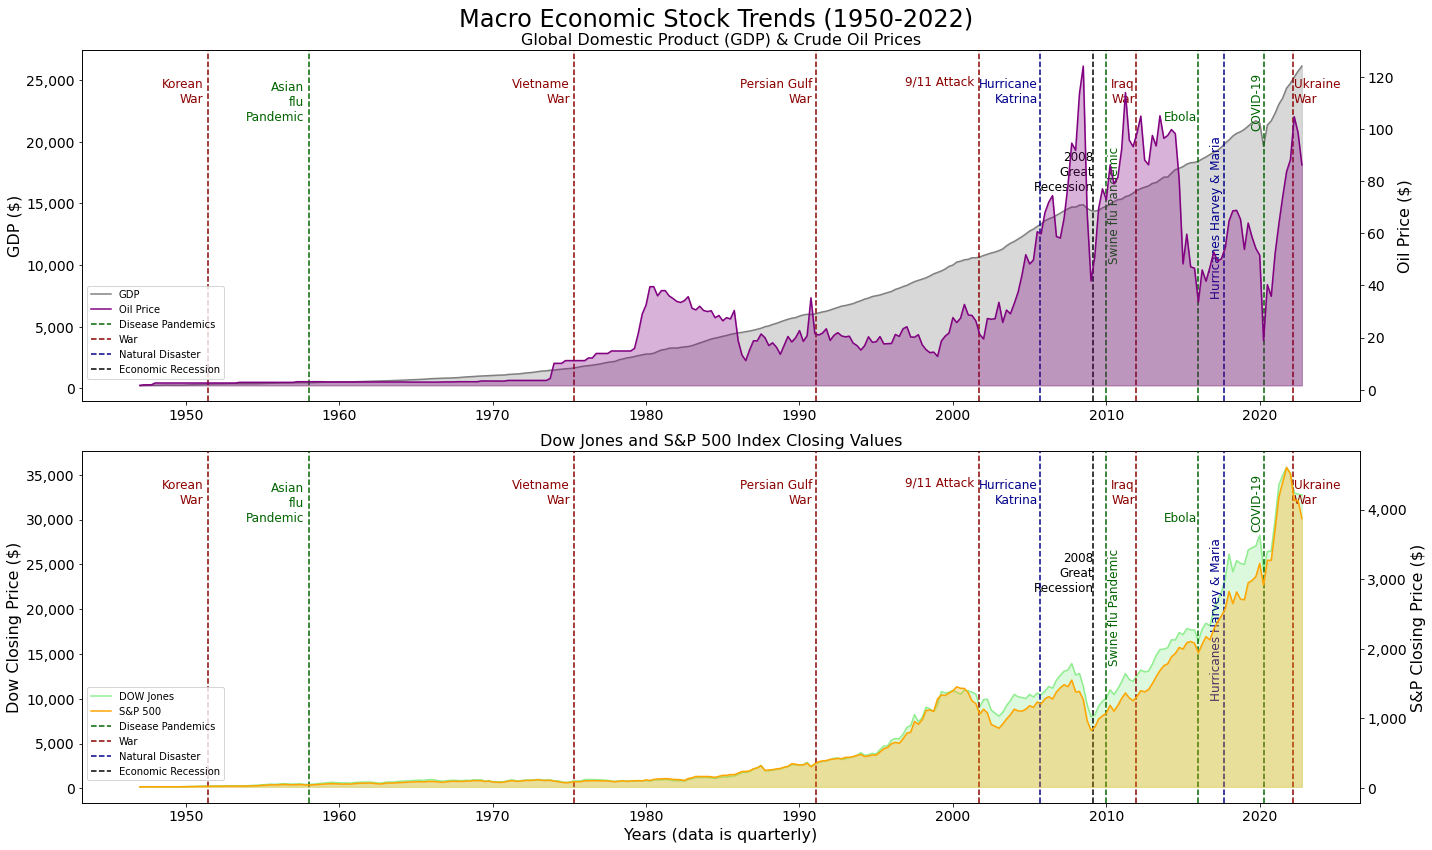

In [159]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(20, 12))

axs[0].plot(df['DATE'], df['GDP'], color='grey')
axs[0].fill_between(df['DATE'], df['GDP'].values.min(), df['GDP'].values, alpha=.3, color='grey')
axs[0].set_title("Global Domestic Product (GDP) & Crude Oil Prices", fontsize=16)
axs[0].yaxis.set_major_formatter(formatter)
axs[0].tick_params(axis='y', labelsize=14)
axs[0].set_ylabel("GDP ($)", fontsize=16)
axs[0].tick_params(axis='x', labelsize=14)

ax2 = axs[0].twinx()

ax2.plot(df['DATE'], df['crude_nominal'], color='purple')
ax2.fill_between(df['DATE'], df['crude_nominal'].values.min(), df['crude_nominal'].values, alpha=.3, color='purple')
ax2.yaxis.set_major_formatter(formatter)
ax2.tick_params(axis='y', labelsize=14)
ax2.set_ylabel("Oil Price ($)", fontsize=16)

axs[1].plot(df['DATE'], df['dow_nominal'], color='lightgreen')
axs[1].fill_between(df['DATE'], df['dow_nominal'].values.min(), df['dow_nominal'].values, alpha=.3, color='lightgreen')
axs[1].set_title("Dow Jones and S&P 500 Index Closing Values", fontsize=16)
axs[1].yaxis.set_major_formatter(formatter)
axs[1].tick_params(axis='y', labelsize=14)
axs[1].set_ylabel("Dow Closing Price ($)", fontsize=16)
axs[1].set_xlabel("Years (data is quarterly)", fontsize=16)
axs[1].tick_params(axis='x', labelsize=14)

ax3 = axs[1].twinx()

ax3.plot(df['DATE'], df['snp_nominal'], color='orange')
ax3.fill_between(df['DATE'], df['snp_nominal'].values.min(), df['snp_nominal'].values, alpha=.3, color='orange')
ax3.yaxis.set_major_formatter(formatter)
ax3.tick_params(axis='y', labelsize=14)
ax3.set_ylabel("S&P Closing Price ($)", fontsize=16)


########### economic recessions ################## (black)
add_axv_line(axs, datetime(year=2009, month=3, day=1), '2008\nGreat\nRecession', rotation=0, fontsize=12, offset_percent=0.4, ha='right')
########## natural disasters ################### (some other color)
add_axv_line(axs, datetime(year=2005, month=8, day=31), 'Hurricane\nKatrina', rotation=0, fontsize=12, offset_percent=0.15, ha='right', label_color='darkblue', line_color='darkblue', label_offset=50)
add_axv_line(axs, datetime(year=2017, month=9, day=3), 'Hurricanes Harvey & Maria', rotation=90, fontsize=12, offset_percent=0.7, ha='right', label_color='darkblue', line_color='darkblue', label_offset=30)
########## disease pandemic and epidemics ################ (dark green)
add_axv_line(axs, datetime(year=2020, month=4, day=1), 'COVID-19', rotation=90, fontsize=12, offset_percent=0.22, ha='right', label_color='darkgreen', line_color='darkgreen')
add_axv_line(axs, datetime(year=2010, month=1, day=1), 'Swine flu Pandemic', rotation=90, fontsize=12, offset_percent=0.6, ha='right', label_color='darkgreen', line_color='darkgreen', label_offset=-350)
add_axv_line(axs, datetime(year=1958, month=1, day=1), 'Asian\nflu\nPandemic', rotation=0, fontsize=12, offset_percent=0.2, ha='right', label_color='darkgreen', line_color='darkgreen', label_offset=100)
add_axv_line(axs, datetime(year=2016, month=1, day=1), 'Ebola', rotation=0, fontsize=12, offset_percent=0.2, ha='right', label_color='darkgreen', line_color='darkgreen', label_offset=30)
########## war related things ################### (probably red)
add_axv_line(axs, datetime(year=1975, month=4, day=30), 'Vietname\nWar', rotation=0, fontsize=12, offset_percent=0.15, ha='right', label_color='darkred', line_color='darkred', label_offset=100)
add_axv_line(axs, datetime(year=2011, month=12, day=15), 'Iraq\nWar', rotation=0, fontsize=12, offset_percent=0.15, ha='right', label_color='darkred', line_color='darkred', label_offset=30)
add_axv_line(axs, datetime(year=2022, month=2, day=24), 'Ukraine\nWar', rotation=0, fontsize=12, offset_percent=0.15, ha='left', label_color='darkred', line_color='darkred', label_offset=-30)
add_axv_line(axs, datetime(year=1951, month=6, day=1), 'Korean\nWar', rotation=0, fontsize=12, offset_percent=0.15, ha='right', label_color='darkred', line_color='darkred', label_offset=100)
add_axv_line(axs, datetime(year=1991, month=2, day=1), 'Persian Gulf\nWar', rotation=0, fontsize=12, offset_percent=0.15, ha='right', label_color='darkred', line_color='darkred', label_offset=100)
add_axv_line(axs, datetime(year=2001, month=9, day=11), '9/11 Attack', rotation=0, fontsize=12, offset_percent=0.1, ha='right', label_color='darkred', line_color='darkred', label_offset=100)


custom_legend = [
    plt.Line2D([], [], color='grey', linestyle='-', label='GDP'),
    plt.Line2D([], [], color='purple', linestyle='-', label='Oil Price'),
    plt.Line2D([], [], color='darkgreen', linestyle='--', label='Disease Pandemics'),
    plt.Line2D([], [], color='darkred', linestyle='--', label='War'),
    plt.Line2D([], [], color='darkblue', linestyle='--', label='Natural Disaster'),
    plt.Line2D([], [], color='black', linestyle='--', label='Economic Recession')
]

# Add the custom legend to the plot
axs[0].legend(handles=custom_legend, bbox_to_anchor=(0, 0.05), loc='lower left')

custom_legend2 = [
    plt.Line2D([], [], color='lightgreen', linestyle='-', label='DOW Jones'),
    plt.Line2D([], [], color='orange', linestyle='-', label='S&P 500'),
    plt.Line2D([], [], color='darkgreen', linestyle='--', label='Disease Pandemics'),
    plt.Line2D([], [], color='darkred', linestyle='--', label='War'),
    plt.Line2D([], [], color='darkblue', linestyle='--', label='Natural Disaster'),
    plt.Line2D([], [], color='black', linestyle='--', label='Economic Recession')
]

axs[1].legend(handles=custom_legend2, bbox_to_anchor=(0, 0.05), loc='lower left')

fig.suptitle("Macro Economic Stock Trends (1950-2022)", fontsize=24)
fig.tight_layout()
plt.subplots_adjust(top=0.93)

In [ ]:
np.log10()

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(20, 12))

axs[0].plot(df['DATE'], df['GDP'], color='grey')
axs[0].fill_between(df['DATE'], df['GDP'].values.min(), df['GDP'].values, alpha=.3, color='grey')
axs[0].set_title("Global Domestic Product (GDP) & Crude Oil Prices", fontsize=16)
axs[0].yaxis.set_major_formatter(formatter)
axs[0].tick_params(axis='y', labelsize=14)
axs[0].set_ylabel("GDP ($)", fontsize=16)
axs[0].tick_params(axis='x', labelsize=14)

ax2 = axs[0].twinx()

ax2.plot(df['DATE'], df['crude_nominal'], color='purple')
ax2.fill_between(df['DATE'], df['crude_nominal'].values.min(), df['crude_nominal'].values, alpha=.3, color='purple')
ax2.yaxis.set_major_formatter(formatter)
ax2.tick_params(axis='y', labelsize=14)
ax2.set_ylabel("Oil Price ($)", fontsize=16)

axs[1].plot(df['DATE'], df['dow_nominal'], color='lightgreen')
axs[1].fill_between(df['DATE'], df['dow_nominal'].values.min(), df['dow_nominal'].values, alpha=.3, color='lightgreen')
axs[1].set_title("Dow Jones and S&P 500 Index Closing Values", fontsize=16)
axs[1].yaxis.set_major_formatter(formatter)
axs[1].tick_params(axis='y', labelsize=14)
axs[1].set_ylabel("Dow Closing Price ($)", fontsize=16)
axs[1].set_xlabel("Years (data is quarterly)", fontsize=16)
axs[1].tick_params(axis='x', labelsize=14)

ax3 = axs[1].twinx()

ax3.plot(df['DATE'], df['snp_nominal'], color='orange')
ax3.fill_between(df['DATE'], df['snp_nominal'].values.min(), df['snp_nominal'].values, alpha=.3, color='orange')
ax3.yaxis.set_major_formatter(formatter)
ax3.tick_params(axis='y', labelsize=14)
ax3.set_ylabel("S&P Closing Price ($)", fontsize=16)


########### economic recessions ################## (black)
add_axv_line(axs, datetime(year=2009, month=3, day=1), '2008\nGreat\nRecession', rotation=0, fontsize=12, offset_percent=0.4, ha='right')
########## natural disasters ################### (some other color)
add_axv_line(axs, datetime(year=2005, month=8, day=31), 'Hurricane\nKatrina', rotation=0, fontsize=12, offset_percent=0.15, ha='right', label_color='darkblue', line_color='darkblue', label_offset=50)
add_axv_line(axs, datetime(year=2017, month=9, day=3), 'Hurricanes Harvey & Maria', rotation=90, fontsize=12, offset_percent=0.7, ha='right', label_color='darkblue', line_color='darkblue', label_offset=30)
########## disease pandemic and epidemics ################ (dark green)
add_axv_line(axs, datetime(year=2020, month=4, day=1), 'COVID-19', rotation=90, fontsize=12, offset_percent=0.22, ha='right', label_color='darkgreen', line_color='darkgreen')
add_axv_line(axs, datetime(year=2010, month=1, day=1), 'Swine flu Pandemic', rotation=90, fontsize=12, offset_percent=0.6, ha='right', label_color='darkgreen', line_color='darkgreen', label_offset=-350)
add_axv_line(axs, datetime(year=1958, month=1, day=1), 'Asian\nflu\nPandemic', rotation=0, fontsize=12, offset_percent=0.2, ha='right', label_color='darkgreen', line_color='darkgreen', label_offset=100)
add_axv_line(axs, datetime(year=2016, month=1, day=1), 'Ebola', rotation=0, fontsize=12, offset_percent=0.2, ha='right', label_color='darkgreen', line_color='darkgreen', label_offset=30)
########## war related things ################### (probably red)
add_axv_line(axs, datetime(year=1975, month=4, day=30), 'Vietname\nWar', rotation=0, fontsize=12, offset_percent=0.15, ha='right', label_color='darkred', line_color='darkred', label_offset=100)
add_axv_line(axs, datetime(year=2011, month=12, day=15), 'Iraq\nWar', rotation=0, fontsize=12, offset_percent=0.15, ha='right', label_color='darkred', line_color='darkred', label_offset=30)
add_axv_line(axs, datetime(year=2022, month=2, day=24), 'Ukraine\nWar', rotation=0, fontsize=12, offset_percent=0.15, ha='left', label_color='darkred', line_color='darkred', label_offset=-30)
add_axv_line(axs, datetime(year=1951, month=6, day=1), 'Korean\nWar', rotation=0, fontsize=12, offset_percent=0.15, ha='right', label_color='darkred', line_color='darkred', label_offset=100)
add_axv_line(axs, datetime(year=1991, month=2, day=1), 'Persian Gulf\nWar', rotation=0, fontsize=12, offset_percent=0.15, ha='right', label_color='darkred', line_color='darkred', label_offset=100)
add_axv_line(axs, datetime(year=2001, month=9, day=11), '9/11 Attack', rotation=0, fontsize=12, offset_percent=0.1, ha='right', label_color='darkred', line_color='darkred', label_offset=100)


custom_legend = [
    plt.Line2D([], [], color='grey', linestyle='-', label='GDP'),
    plt.Line2D([], [], color='purple', linestyle='-', label='Oil Price'),
    plt.Line2D([], [], color='darkgreen', linestyle='--', label='Disease Pandemics'),
    plt.Line2D([], [], color='darkred', linestyle='--', label='War'),
    plt.Line2D([], [], color='darkblue', linestyle='--', label='Natural Disaster'),
    plt.Line2D([], [], color='black', linestyle='--', label='Economic Recession')
]

# Add the custom legend to the plot
axs[0].legend(handles=custom_legend, bbox_to_anchor=(0, 0.05), loc='lower left')

custom_legend2 = [
    plt.Line2D([], [], color='lightgreen', linestyle='-', label='DOW Jones'),
    plt.Line2D([], [], color='orange', linestyle='-', label='S&P 500'),
    plt.Line2D([], [], color='darkgreen', linestyle='--', label='Disease Pandemics'),
    plt.Line2D([], [], color='darkred', linestyle='--', label='War'),
    plt.Line2D([], [], color='darkblue', linestyle='--', label='Natural Disaster'),
    plt.Line2D([], [], color='black', linestyle='--', label='Economic Recession')
]

axs[1].legend(handles=custom_legend2, bbox_to_anchor=(0, 0.05), loc='lower left')

fig.suptitle("Macro Economic Stock Trends (1950-2022)", fontsize=24)
fig.tight_layout()
plt.subplots_adjust(top=0.93)